In [1]:
import os
import pandas as pd
from spacy import load
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from matplotlib import pyplot as plt
import pickle

## Read in the files into a dataframe

In [2]:
# set the path to the folder with all of the text files
path = '../emails'

# obtain a list of all files in the path
file_list = os.listdir(path)

In [3]:
# empty dictionary to store the text file contents
email_dict = dict()
email_dict['file'] =[]
email_dict['subject'] =[]
email_dict['subject_length'] =[]
email_dict['text'] =[]
email_dict['text_length'] =[]
email_dict['class'] =[]


# loop over files and read their contents
for file in file_list:
    file_path = os.path.join(path,file)
    email_dict['file'].append(file)
    
    # check whether classified as ham or spam
    if file.startswith('spms'):
        email_dict['class'].append(1)
    else:
        email_dict['class'].append(0)
    
    # Store the contents of the file as list items
    with open(file_path,'r')as f:
        subject = f.readlines()[0].split(' ', 1)[1].lower()
        f.seek(0)
        text = f.readlines()[2:][0]
        email_dict['subject'].append(subject)
        email_dict['text'].append(text)
        email_dict['text_length'].append(len(text))
        email_dict['subject_length'].append(len(subject))
    
    

In [4]:
# Create a dataframe 'df' containing the content from 'email_dict'
df = pd.DataFrame.from_dict(email_dict)

# Replace any newlines with empty strings
df = df.replace(r'\n','', regex=True) 

# randomly shuffle select only 0.3
df = df.sample(frac=1,random_state=42).reset_index(drop=True)
df.to_csv('emails.csv', index=False)
df.head()

,file,subject,subject_length,text,text_length,class
0,9-208msg1.txt,"a workshop on text , speech and dialog ( tsd '...",52,first announcement and call for papers a works...,6327,0
1,6-863msg1.txt,re : toc,9,"dear colleague , i would like to send you the ...",1265,0
2,spmsga152.txt,free internet services & unique shopping,41,here 's a great directory for free and interes...,553,1
3,6-977msg1.txt,summary,8,"dear all , i send you a summary of the answers...",6793,0
4,8-1096msg1.txt,summary : vowel deletion between two like cons...,53,"quite some time ago , i wrote requesting infor...",5793,0


In [5]:
df.shape

(2893, 6)

In [6]:
# read contents of the text  from the first row
df['text'][0]

'first announcement and call for papers a workshop on text , speech and dialog ( tsd \' 98 ) brno , czech republic , 23-26 september 1998 the workshop is organized by the faculty of informatics , masaryk university , brno , and the faculty of applied sciences , university of west bohemia , pilsen , under the auspices of the dean of the faculty of informatics of masaryk university . please visit the workshop \'s homepage : http : / / www . fi . muni . cz / tsd98 / venue brno , czech republic topics tsd \' 98 will be concerned with topics in the field of natural language processing , in particular : - corpora , texts and transcription - speech analysis , recognition and synthesis - their intertwining within nl dialog systems . topics of the workshop will include ( but are not limited to ) : - text corpora and tagging - transcription problems in spoken corpora - sense disambiguation - links between text and speech oriented systems - parsing issues , especially parsing problems in spoken t

### Check for empty cells

In [7]:
df.isnull().sum()

file              0
subject           0
subject_length    0
text              0
text_length       0
class             0
dtype: int64

## Load the spacy library

In [8]:
nlp = load('en_core_web_sm')

In [9]:
doc = nlp(df['text'][2])

## Remove Punctuation

In [10]:
text1 = df['text'][2]
text1 
#table = str.maketrans('', '', string.punctuation)

'here \'s a great directory for free and interesting internet sites ! ! ! visit " mall direct " http : / / 209 . 125 . 202 . 59 this is a fabulous list , please save for future reference . - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - to be removed from this list , please enter your e-mail address at http : / / www . remove-list . com - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -'

In [11]:
# Remove punctuation from text  
table = str.maketrans('', '', string.punctuation)

df['subject_stripped'] = df['subject'].apply(lambda words: "".join([w.translate(table) for w in words]).strip())
df['text_stripped'] = df['text'].apply(lambda words: "".join([w.translate(table) for w in words]).strip())


## Lemmatize Text 

In [12]:
df["subject_lemmatized"] = df['subject_stripped'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
df["text_lemmatized"] = df['text_stripped'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))

In [13]:
df['subject_lemmatized'][4]

'summary   vowel deletion between two like consonant'

## Remove Stop Words

In [14]:
def remove_stops(text):
    """Function to remove most common stop words from text"""
    my_doc = nlp(text)

    # create list of token words
    token_list= [token.text for token in my_doc]

    # return list of word tokens after removing stopwords
    return [word for word in token_list if nlp.vocab[word].is_stop == False]
 

In [15]:
df['text_no_stops'] = df['text_lemmatized'].apply(lambda text:" ".join(remove_stops(text)))
df['subject_no_stops'] = df['subject_lemmatized'].apply(lambda text:" ".join(remove_stops(text)))

In [16]:
df.head()

,file,subject,subject_length,text,text_length,class,subject_stripped,text_stripped,subject_lemmatized,text_lemmatized,text_no_stops,subject_no_stops
0,9-208msg1.txt,"a workshop on text , speech and dialog ( tsd '...",52,first announcement and call for papers a works...,6327,0,a workshop on text speech and dialog tsd 98,first announcement and call for papers a works...,a workshop on text speech and dialog tsd 98,first announcement and call for paper a worksh...,announcement paper workshop text speech dia...,workshop text speech dialog tsd 98
1,6-863msg1.txt,re : toc,9,"dear colleague , i would like to send you the ...",1265,0,re toc,dear colleague i would like to send you the f...,re toc,dear colleague i would like to send -PRON- t...,dear colleague like send -PRON- follow anno...,toc
2,spmsga152.txt,free internet services & unique shopping,41,here 's a great directory for free and interes...,553,1,free internet services unique shopping,here s a great directory for free and interest...,free internet service unique shopping,here s a great directory for free and interest...,s great directory free interesting internet si...,free internet service unique shopping
3,6-977msg1.txt,summary,8,"dear all , i send you a summary of the answers...",6793,0,summary,dear all i send you a summary of the answers ...,summary,dear all i send -PRON- a summary of the answ...,dear send -PRON- summary answer -PRON- quer...,summary
4,8-1096msg1.txt,summary : vowel deletion between two like cons...,53,"quite some time ago , i wrote requesting infor...",5793,0,summary vowel deletion between two like conso...,quite some time ago i wrote requesting inform...,summary vowel deletion between two like cons...,quite some time ago i write request informat...,time ago write request information concern ...,summary vowel deletion like consonant


In [17]:
df.to_csv('emails_lemmatised.csv', index=False)

## Topic Modelling

In [47]:
cv = CountVectorizer(max_df=0.95, min_df=2,token_pattern='[A-Za-z]*')

In [48]:
dtm_text = cv.fit_transform(df['text_no_stops'])

In [49]:
LDA = LatentDirichletAllocation(n_components=6,random_state=42)

In [50]:
LDA.fit(dtm_text)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=6, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [51]:
len(cv.get_feature_names())

23083

In [52]:
# Print out the most common words
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['berlin', 'universite', 'fax', 'gruyter', 'pron', 'und', 'du', 'e', 'der', 'les', 'h', 'le', 'benjamin', 'des', 'en', 'd', 'et', 'l', 'la', 'de']


THE TOP 15 WORDS FOR TOPIC #1
['pp', 'example', 'new', 'e', 'linguist', 'work', 'grammar', 'case', 'study', 'university', 'edu', 'word', 'theory', 'book', 'use', 'english', 's', 'linguistic', 'language', 'pron']


THE TOP 15 WORDS FOR TOPIC #2
['science', 'email', 'computer', 'speech', 'uk', 'text', 'www', 'include', 'http', 'usa', 'research', 'conference', 'system', 'submission', 'language', 'information', 'university', 'workshop', 'pron', 'paper']


THE TOP 15 WORDS FOR TOPIC #3
['business', 'good', 'money', 'use', 'free', 'mail', 'work', 'time', 'receive', 'nt', 'people', 'program', 'list', 'send', 'report', 'address', 'order', 'email', 's', 'pron']


THE TOP 15 WORDS FOR TOPIC #4
['discourse', 'word', 'linguistic', 'p', 'japanese', 'c', 'n', 'v', 'j', 'language', 'g', 'english', 'university', 'h', 'b', 'e'

In [53]:
topic_dict={0:'Academics',
           1: 'language',
           2:'science',
           3: 'money',
           4:'money',
           5:'administration',    
}

In [54]:
pickle.dump(LDA,open('lda_model.pk', 'wb'))

### Adding Topic to row

In [55]:
topic_results = LDA.transform(dtm_text)

In [56]:
df['topic_number']= topic_results.argmax(axis=1)

In [57]:
df.shape

(2893, 14)

In [58]:
df.head(5)

,file,subject,subject_length,text,text_length,class,subject_stripped,text_stripped,subject_lemmatized,text_lemmatized,text_no_stops,subject_no_stops,topic_number,topic
0,9-208msg1.txt,"a workshop on text , speech and dialog ( tsd '...",52,first announcement and call for papers a works...,6327,0,a workshop on text speech and dialog tsd 98,first announcement and call for papers a works...,a workshop on text speech and dialog tsd 98,first announcement and call for paper a worksh...,announcement paper workshop text speech dia...,workshop text speech dialog tsd 98,2,literature
1,6-863msg1.txt,re : toc,9,"dear colleague , i would like to send you the ...",1265,0,re toc,dear colleague i would like to send you the f...,re toc,dear colleague i would like to send -PRON- t...,dear colleague like send -PRON- follow anno...,toc,1,business
2,spmsga152.txt,free internet services & unique shopping,41,here 's a great directory for free and interes...,553,1,free internet services unique shopping,here s a great directory for free and interest...,free internet service unique shopping,here s a great directory for free and interest...,s great directory free interesting internet si...,free internet service unique shopping,3,education
3,6-977msg1.txt,summary,8,"dear all , i send you a summary of the answers...",6793,0,summary,dear all i send you a summary of the answers ...,summary,dear all i send -PRON- a summary of the answ...,dear send -PRON- summary answer -PRON- quer...,summary,1,web
4,8-1096msg1.txt,summary : vowel deletion between two like cons...,53,"quite some time ago , i wrote requesting infor...",5793,0,summary vowel deletion between two like conso...,quite some time ago i wrote requesting inform...,summary vowel deletion between two like cons...,quite some time ago i write request informat...,time ago write request information concern ...,summary vowel deletion like consonant,1,language


In [59]:
df['topic'] = df['topic_number'].apply(lambda x: topic_dict[x])

In [60]:
df.head(5)

,file,subject,subject_length,text,text_length,class,subject_stripped,text_stripped,subject_lemmatized,text_lemmatized,text_no_stops,subject_no_stops,topic_number,topic
0,9-208msg1.txt,"a workshop on text , speech and dialog ( tsd '...",52,first announcement and call for papers a works...,6327,0,a workshop on text speech and dialog tsd 98,first announcement and call for papers a works...,a workshop on text speech and dialog tsd 98,first announcement and call for paper a worksh...,announcement paper workshop text speech dia...,workshop text speech dialog tsd 98,2,science
1,6-863msg1.txt,re : toc,9,"dear colleague , i would like to send you the ...",1265,0,re toc,dear colleague i would like to send you the f...,re toc,dear colleague i would like to send -PRON- t...,dear colleague like send -PRON- follow anno...,toc,1,language
2,spmsga152.txt,free internet services & unique shopping,41,here 's a great directory for free and interes...,553,1,free internet services unique shopping,here s a great directory for free and interest...,free internet service unique shopping,here s a great directory for free and interest...,s great directory free interesting internet si...,free internet service unique shopping,3,money
3,6-977msg1.txt,summary,8,"dear all , i send you a summary of the answers...",6793,0,summary,dear all i send you a summary of the answers ...,summary,dear all i send -PRON- a summary of the answ...,dear send -PRON- summary answer -PRON- quer...,summary,1,language
4,8-1096msg1.txt,summary : vowel deletion between two like cons...,53,"quite some time ago , i wrote requesting infor...",5793,0,summary vowel deletion between two like conso...,quite some time ago i wrote requesting inform...,summary vowel deletion between two like cons...,quite some time ago i write request informat...,time ago write request information concern ...,summary vowel deletion like consonant,1,language


In [67]:
df.to_csv('emails_cleaned.csv', index=False)

# Analysis and Vizualisation of Data

### Spam vs Ham

Text(0.5, 1.0, 'Count of Class')

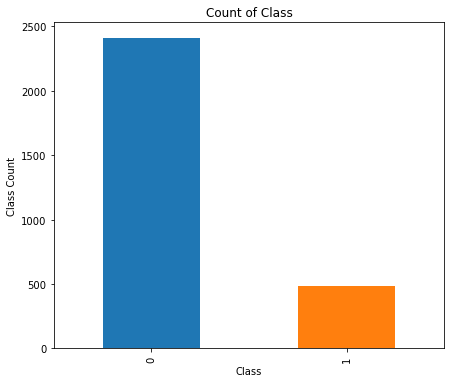

In [61]:
df['class'].value_counts().plot(kind='bar',figsize=(7, 6))
plt.xlabel("Class")
plt.ylabel("Class Count")
plt.title("Count of Class")

The above graph shows that there is a large difference in the number of spam and ham emails with a large majority of the emails being ham. This may lead to a majority bias due to the inbalanced data. Test should be conducted to assess whethere this hypothesis is true and if so methods should be considered to alleviate this imbalance.

### Topic of Text

Text(0.5, 1.0, 'Count of Topics')

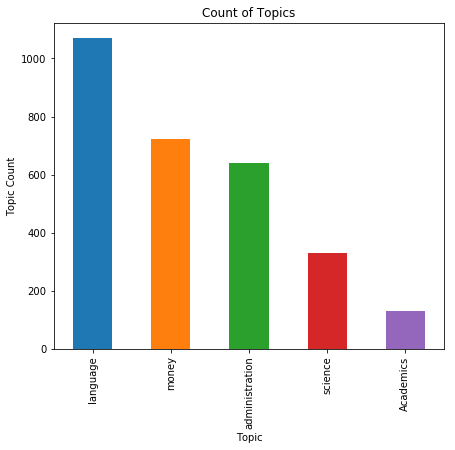

In [62]:
df['topic'].value_counts().plot(kind='bar',figsize=(7, 6))
plt.xlabel("Topic")
plt.ylabel("Topic Count")
plt.title("Count of Topics")

The syntax topic appeare the most while the web topic appears the least commonly. This graph can be seen as an example of Paretos law where by the first topic appears more commonly then when combining the least common features.

In [63]:
df.topic[df['class']==0].value_counts()

language          1067
administration     638
science            330
money              247
Academics          130
Name: topic, dtype: int64

In [64]:
df.topic[df['class']==1].value_counts()

money             477
language            2
science             1
administration      1
Name: topic, dtype: int64

Text(0.5, 1.0, 'Count of Topics')

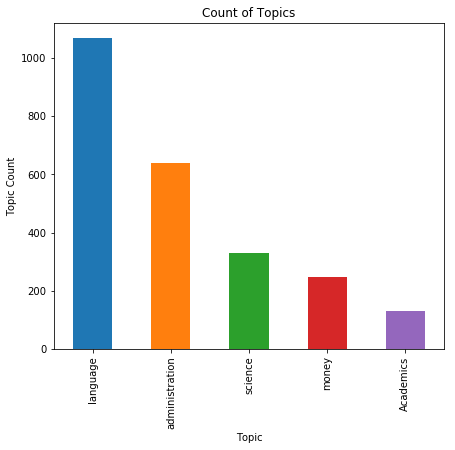

In [65]:
df.topic[df['class']==0].value_counts().plot(kind='bar',figsize=(7, 6))
#df.topic[df['class']==1].value_counts().plot(kind='bar',figsize=(7, 6))
plt.xlabel("Topic")
plt.ylabel("Topic Count")
plt.title("Count of Topics")

Text(0.5, 1.0, 'Count of Topics')

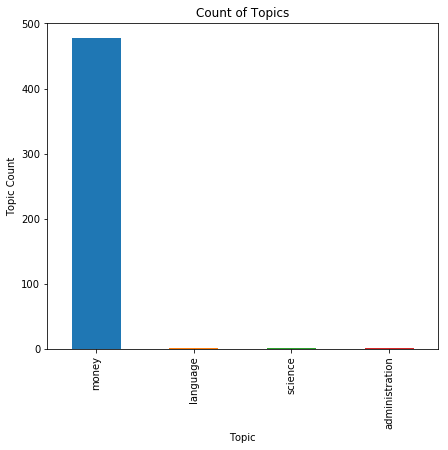

In [66]:
#df.topic[df['class']==0].value_counts().plot(kind='bar',figsize=(7, 6))
df.topic[df['class']==1].value_counts().plot(kind='bar',figsize=(7, 6))
plt.xlabel("Topic")
plt.ylabel("Topic Count")
plt.title("Count of Topics")